# Descripción de datos de texto

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from statistics import mode

from config import DATA_PATH, VISUALIZATIONS_PATH
from notebooks.src.utilities import (
    SPACY_MODEL, preprocess_text, count_tokens, calculate_univariant_metrics
)

In [2]:
sns.set_style("whitegrid")

## Preprocesado

In [3]:
session_speech = pd.read_csv(
    os.path.join(DATA_PATH, "session_speech_speaker_info.csv"),
    converters={"speech": eval},
    )
session_speech.head(2)

,name,vote,senator,province,party,party_family,speaker,speech
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón,"[Hace dos años, tuvimos una sesión histórica c..."
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo,"[Gracias, señor presidente. Hoy es un día en e..."


In [4]:
senators_with_no_speech = (session_speech.speech.str.len()==0).sum()
print(f"{senators_with_no_speech} senadores no intervinieron en la sesión.")

9 senadores no intervinieron en la sesión.


In [5]:
session_speech.shape

(70, 8)

In [6]:
session_speech = (
    session_speech
    .explode("speech")
    .dropna(subset=["speech"], ignore_index=True)
)
session_speech.head(2)

,name,vote,senator,province,party,party_family,speaker,speech
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón,"Hace dos años, tuvimos una sesión histórica cu..."
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo,"Gracias, señor presidente. Hoy es un día en el..."


In [7]:
session_speech.shape

(201, 8)

In [8]:
session_speech["speech_preprocessed"] = session_speech.speech.apply(preprocess_text)

In [9]:
out_file = os.path.join(DATA_PATH, "words2lemmas.json")

with open(out_file, "r") as f:
    words2lemmas = json.load(f)

words2lemmas["es"]

{'VERB': {'lemma': 'ser', 'count': 1247}}

In [10]:
def select_lemma_and_pos(text: str) -> tuple[str, str]:
    lemmatized_text, pos_text = "", ""
    tokens = SPACY_MODEL(text)
    for t in tokens:
        token = preprocess_text(t.text)
        lemmas = words2lemmas.get(token)
        if lemmas is None:
            continue
        if len(lemmas) == 1:
            lemma_value = list(lemmas.values())[0]
            pos = list(lemmas.keys())[0]
        else:
            lemma_value = lemmas.get(t.pos_)
            if lemma_value is None:
                lemma_count = 0
                for key, value in lemmas.items():
                    if value["count"] > lemma_count:
                        lemma_count = value["count"]
                        pos = key
                        lemma_value = value
        lemma = lemma_value.get("lemma")
        if (lemma is None) or (pos is None):
            raise Exception(
                f"Error while processing token {token} ({t.pos}), lemmas found {lemmas}"
            )
        lemmatized_text += f"{lemma} "
        pos_text += f"{pos} "
    return lemmatized_text.strip(), pos_text.strip()

In [11]:
def concatenate_lemma_and_pos(row):
    lemma_pos = list()
    pos = row.speech_pos.split()
    for i, lemma in enumerate(row.speech_lemmas.split()):
        lemma_pos.append((lemma, pos[i]))
    return lemma_pos

In [12]:
session_speech["speech_lemmas"], session_speech["speech_pos"] = (
    zip(*session_speech.speech.apply(select_lemma_and_pos))
)

In [13]:
session_speech["speech_lemma_pos"] = session_speech.apply(concatenate_lemma_and_pos, axis=1)
session_speech[["speech", "speech_lemmas", "speech_pos", "speech_lemma_pos"]].head(2)

,speech,speech_lemmas,speech_pos,speech_lemma_pos
0,"Hace dos años, tuvimos una sesión histórica cu...",hacer año tener una sesión histórica cuando de...,VERB NOUN VERB DET NOUN ADJ SCONJ VERB ADP ADJ...,"[(hacer, VERB), (año, NOUN), (tener, VERB), (u..."
1,"Gracias, señor presidente. Hoy es un día en el...",gracia señor presidente hoy ser un día en el q...,NOUN NOUN NOUN ADV VERB DET NOUN ADP DET SCONJ...,"[(gracia, NOUN), (señor, NOUN), (presidente, N..."


In [14]:
session_speech.vote.unique()

array(['positivo', 'negativo', 'abstención', 'ausente'], dtype=object)

In [15]:
session_speech.shape

(201, 12)

In [16]:
out_file = os.path.join(DATA_PATH, "session_speech.csv")
#session_speech.to_csv(out_file, index=False)

## Métricas de resumen

### Distribución de tokens

In [17]:
columns = session_speech.filter(regex=r"^speech_(lemmas|pos|preprocessed)$").columns.to_list()
metrics = ["count", "count_unique"]

for col in columns:
    for metric in metrics:
        new_col = f"{col}_{metric}"
        print(f"* Calculando {metric} para {col}")
        print(f"** Nueva columna: {new_col}")
        unique = True if "unique" in metric else False
        session_speech[new_col] = session_speech[col].apply(lambda x: count_tokens(x, unique=unique))

* Calculando count para speech_preprocessed
** Nueva columna: speech_preprocessed_count
* Calculando count_unique para speech_preprocessed
** Nueva columna: speech_preprocessed_count_unique
* Calculando count para speech_lemmas
** Nueva columna: speech_lemmas_count
* Calculando count_unique para speech_lemmas
** Nueva columna: speech_lemmas_count_unique
* Calculando count para speech_pos
** Nueva columna: speech_pos_count
* Calculando count_unique para speech_pos
** Nueva columna: speech_pos_count_unique


In [18]:
session_speech["speech_lemma_pos_count_unique"] = (
    session_speech.speech_lemma_pos.apply(lambda x: len(set(x)))
)

In [19]:
session_speech.filter(regex="count").head()

,speech_preprocessed_count,speech_preprocessed_count_unique,speech_lemmas_count,speech_lemmas_count_unique,speech_pos_count,speech_pos_count_unique,speech_lemma_pos_count_unique
0,1723,602,1684,459,1684,10,462
1,411,187,405,146,405,10,147
2,1155,443,1144,365,1144,10,372
3,1075,452,1070,397,1070,10,402
4,1486,576,1479,460,1479,10,463


In [20]:
(
    session_speech
    .filter(regex=r"name|count")
    .groupby("name")
    .agg([np.mean, np.median, np.std])
    .fillna(0)
).head()

speech_preprocessed_count                       \
                                                 mean  median          std   
name                                                                         
Alberto Edgardo Weretilneck                    1155.0   145.0  1874.577019   
Alfredo Héctor Luenzo                           784.0   784.0   219.203102   
Alfredo Luis De Angeli                          844.0   844.0     0.000000   
Ana Claudia Almirón                            1723.0  1723.0     0.000000   
Ana María Ianni                                 218.2     8.0   290.745077   

                            speech_preprocessed_count_unique         \
                                                        mean median   
name                                                                  
Alberto Edgardo Weretilneck                            359.0   88.0   
Alfredo Héctor Luenzo                                  287.5  287.5   
Alfredo Luis De Angeli                                 345.0  345.0   
Ana Claudia Almirón                                    602.0  602.0   
Ana María Ianni                                         95.6    8.0   

                                        speech_lemmas_count          \
                                    std                mean  median   
name                                                                  
Alberto Edgardo Weretilneck  545.561179         1123.333333   144.0   
Alfredo Héctor Luenzo         74.246212          780.500000   780.5   
Alfredo Luis De Angeli         0.000000          835.000000   835.0   
Ana Claudia Almirón            0.000000         1684.000000  1684.0   
Ana María Ianni              124.660740          216.200000     8.0   

                                         speech_lemmas_count_unique  ...  \
                                     std                       mean  ...   
name                                                                 ...   
Alberto Edgardo Weretilneck  1820.615647                 263.333333  ...   
Alfredo Héctor Luenzo         218.495995                 239.500000  ...   
Alfredo Luis De Angeli          0.000000                 262.000000  ...   
Ana Claudia Almirón             0.000000                 459.000000  ...   
Ana María Ianni               288.109701                  79.600000  ...   

                                        speech_pos_count                       \
                                    std             mean  median          std   
name                                                                            
Alberto Edgardo Weretilneck  383.017406      1123.333333   144.0  1820.615647   
Alfredo Héctor Luenzo         57.275649       780.500000   780.5   218.495995   
Alfredo Luis De Angeli         0.000000       835.000000   835.0     0.000000   
Ana Claudia Almirón            0.000000      1684.000000  1684.0     0.000000   
Ana María Ianni              101.829760       216.200000     8.0   288.109701   

                            speech_pos_count_unique                   \
                                               mean median       std   
name                                                                   
Alberto Edgardo Weretilneck                     7.0    9.0  4.358899   
Alfredo Héctor Luenzo                          10.0   10.0  0.000000   
Alfredo Luis De Angeli                         10.0   10.0  0.000000   
Ana Claudia Almirón                            10.0   10.0  0.000000   
Ana María Ianni                                 6.2    5.0  3.633180   

                            speech_lemma_pos_count_unique                     
                                                     mean median         std  
name                                                                          
Alberto Edgardo Weretilneck                         267.0   85.0  389.331478  
Alfredo Héctor Luenzo                               242.0  242.0   56.568542  
Alfredo Luis De Angeli             

In [19]:
(
    session_speech
    .filter(regex=r"vote|count")
    .groupby("vote")
    .agg([np.mean, np.median, np.std])
    .fillna(0)
).head()

speech_preprocessed_count                      \
                                mean  median         std   
vote                                                       
abstención                192.000000   192.0    0.000000   
ausente                  1143.000000  1143.0    0.000000   
negativo                  349.761364     8.0  661.138151   
positivo                  516.711712    13.0  826.768753   

           speech_preprocessed_count_unique                     \
                                       mean median         std   
vote                                                             
abstención                       116.000000  116.0    0.000000   
ausente                          443.000000  443.0    0.000000   
negativo                         136.897727    8.0  224.504412   
positivo                         185.108108   12.0  269.485953   

           speech_lemmas_count                     speech_lemmas_count_unique  \
                          mean  median         std                       mean   
vote                                                                            
abstención          190.000000   190.0    0.000000                 109.000000   
ausente            1140.000000  1140.0    0.000000                 351.000000   
negativo            346.227273     8.0  653.781568                 111.204545   
positivo            510.927928    13.0  816.123717                 144.468468   

            ...             speech_pos_count                      \
            ...         std             mean  median         std   
vote        ...                                                    
abstención  ...    0.000000       190.000000   190.0    0.000000   
ausente     ...    0.000000      1140.000000  1140.0    0.000000   
negativo    ...  175.437853       346.227273     8.0  653.781568   
positivo    ...  203.290514       510.927928    13.0  816.123717   

           speech_pos_count_unique                   \
                              mean median       std   
vote                                                  
abstención               10.000000   10.0  0.000000   
ausente                  10.000000   10.0  0.000000   
negativo                  6.215909    5.0  3.217941   
positivo                  6.576577    6.0  3.369784   

           speech_lemma_pos_count_unique                     
                                    mean median         std  
vote                                                         
abstención                    109.000000  109.0    0.000000  
ausente                       355.000000  355.0    0.000000  
negativo                      112.215909    8.0  177.314997  
positivo                      145.837838   12.0  205.426720  

[4 rows x 21 columns]

### Cantidad de intervenciones

#### Por voto

In [20]:
speech_distrib_by_vote = (
    session_speech
    .groupby("vote")["speech"]
    .apply(lambda x: len(pd.Series(x).to_list()))
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
)
speech_distrib_by_vote

,vote,speech
0,positivo,111
1,negativo,88
2,abstención,1
3,ausente,1


In [21]:
(
    session_speech
    .groupby(["name", "vote"])["speech"]
    .apply(lambda x: len(pd.Series(x).to_list()))
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
    .groupby("vote")["speech"]
    .agg([np.mean, np.median, mode])
    .sort_values(by="mean", ascending=False)
)

,mean,median,mode
vote,,,
negativo,4.0,1.0,1
positivo,3.0,2.0,1
abstención,1.0,1.0,1
ausente,1.0,1.0,1


#### Por senador

In [22]:
speech_distrib_by_senator = (
    session_speech
    .groupby(["name", "vote"])["speech"]
    .apply(lambda x: len(pd.Series(x).to_list()))
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
)
speech_distrib_by_senator

,name,vote,speech
0,Claudia Ledesma Abdala,negativo,46
1,Martín Lousteau,positivo,21
2,Laura Rodríguez Machado,positivo,19
3,Enrique Dalmacio Mera,negativo,8
4,Stella Maris Olalla,positivo,5
...,...,...,...
56,María Clara Del Valle Vega,ausente,1
57,María De Los Ángeles Sacnun,positivo,1
58,María Eugenia Catalfamo,positivo,1
59,Guadalupe Tagliaferri,positivo,1


## Visualizaciones

In [23]:
#session_speech = (
#    session_speech[session_speech.vote.isin(["positivo", "negativo"])]
#    .reset_index(drop=True)
#)
speech_distrib_by_senator = (
    speech_distrib_by_senator[
        speech_distrib_by_senator.vote.isin(["positivo", "negativo"])
    ]
    .reset_index(drop=True)
)

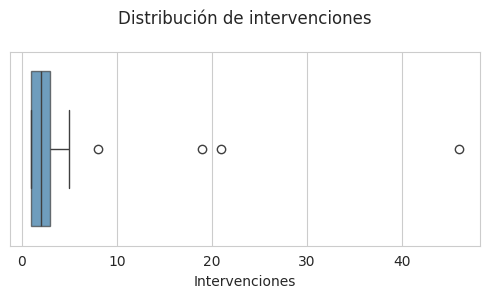

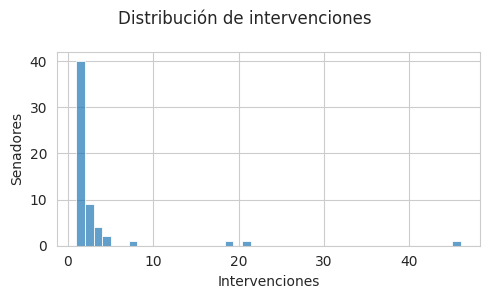

In [24]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_interventions")
os.makedirs(FOLDER, exist_ok=True)

graphs = ["boxplot", "histplot"]

for g in graphs:
    fig, ax = plt.subplots(figsize=(5,3))

    graph = getattr(sns, g)
    alpha = {"alpha": .7}
    kwargs = alpha if g=="histplot" else {"boxprops": alpha}
    graph(speech_distrib_by_senator, x="speech", ax=ax, **kwargs)
    ax.set_xlabel("Intervenciones")
    if g == "histplot":
        ax.set_ylabel("Senadores")
    plt.suptitle("Distribución de intervenciones")
    plt.tight_layout()
    
    plt.savefig(
        os.path.join(FOLDER, f"distrib_{g}_interventions.png")
    )

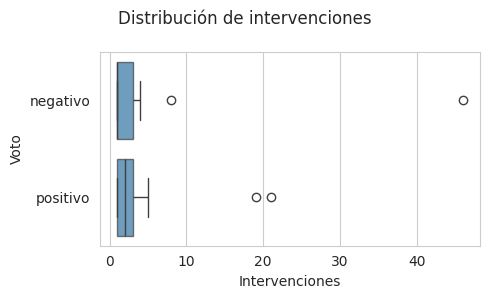

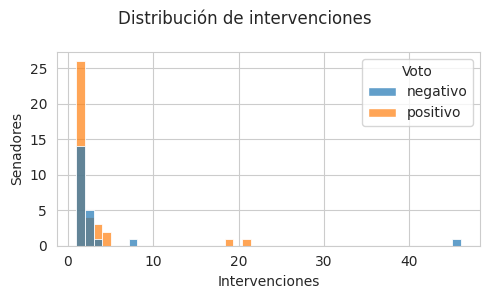

In [25]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_interventions_hue_vote")
os.makedirs(FOLDER, exist_ok=True)

graphs = ["boxplot", "histplot"]

for g in graphs:
    fig, ax = plt.subplots(figsize=(5,3))

    graph = getattr(sns, g)
    alpha = {"alpha": .7}
    kwargs = {"boxprops": alpha, "y": "vote"} if g=="boxplot" else {"hue": "vote", **alpha}
    graph(speech_distrib_by_senator, x="speech", ax=ax, **kwargs)
    ax.set_xlabel("Intervenciones")
    if g == "histplot":
        ax.set_ylabel("Senadores")
        ax.legend_.set_title("Voto")
    else:
        ax.set_ylabel("Voto")
    plt.suptitle("Distribución de intervenciones")
    plt.tight_layout()
    
    plt.savefig(
        os.path.join(FOLDER, f"distrib_{g}_interventions.png")
    )

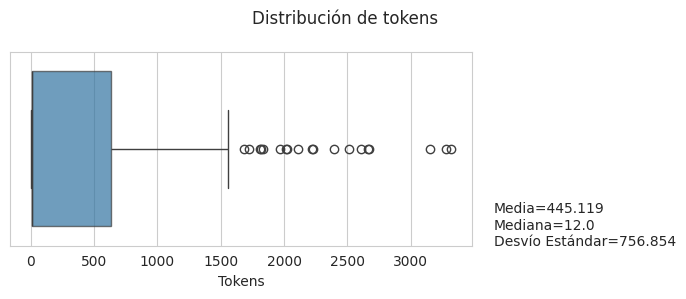

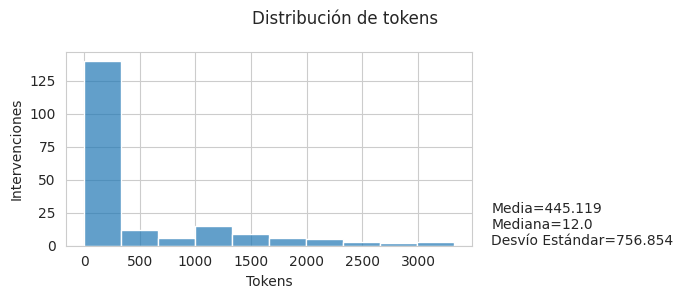

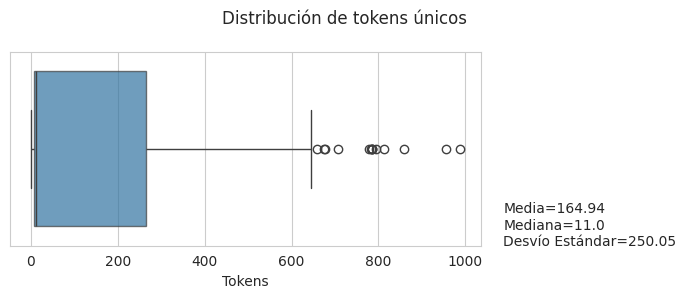

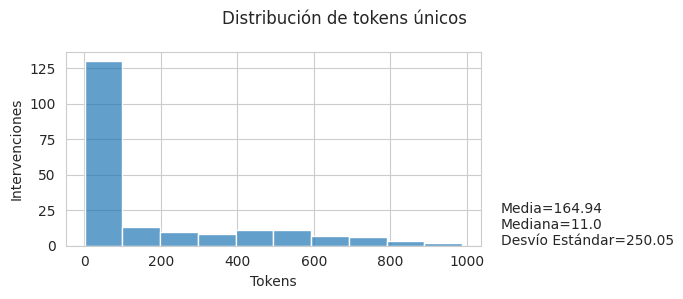

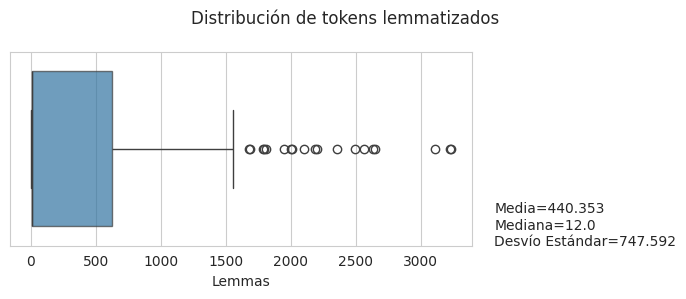

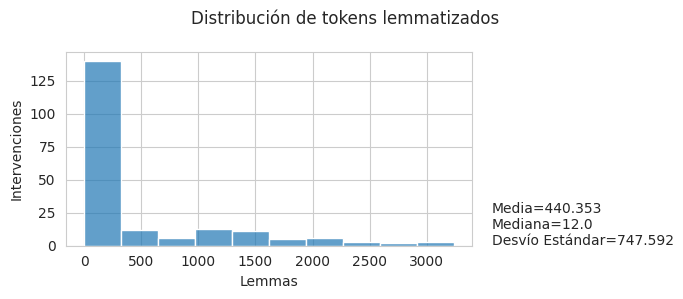

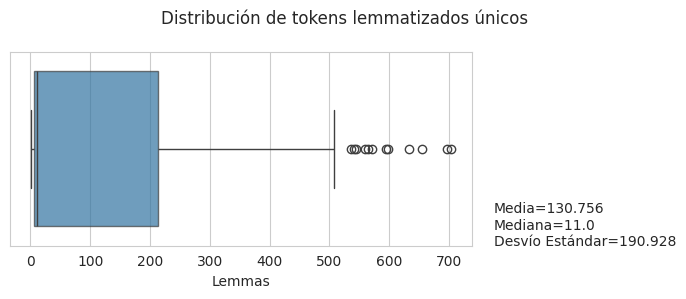

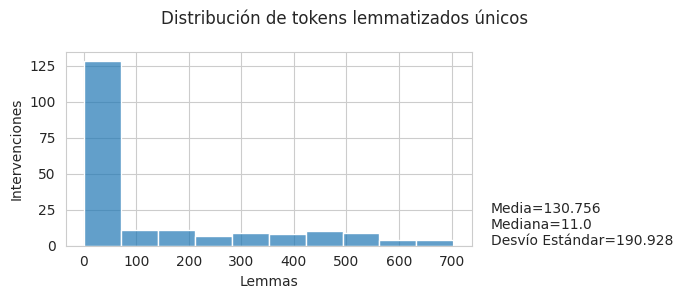

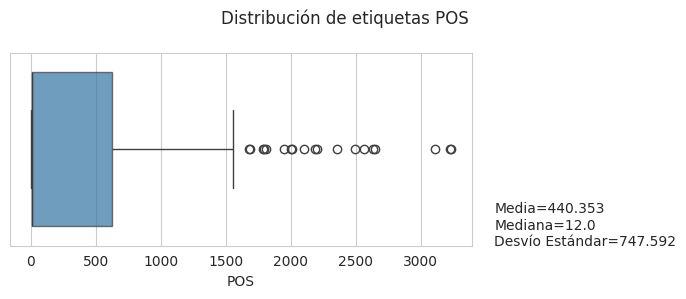

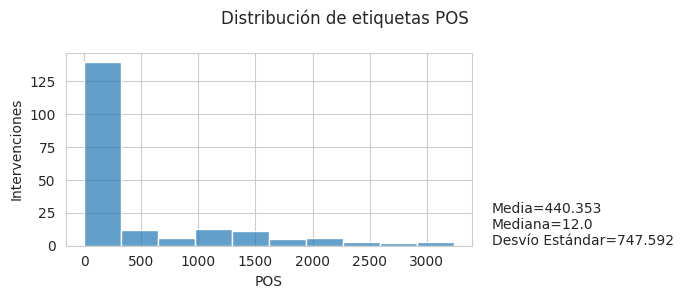

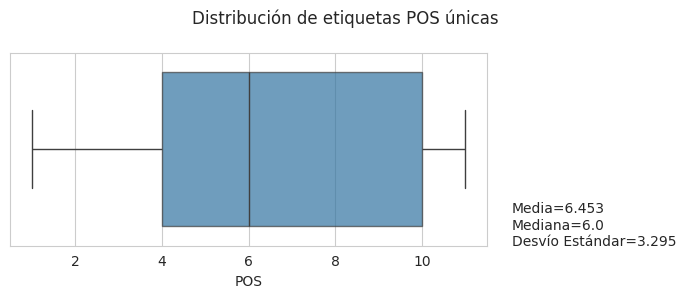

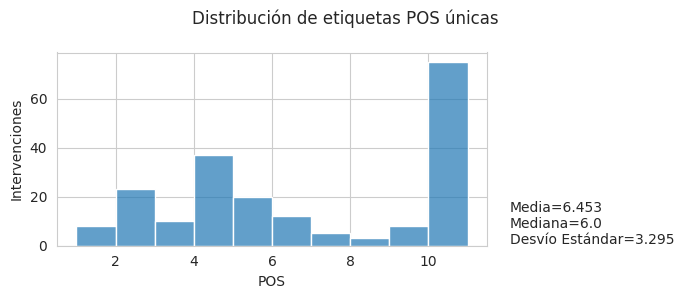

In [26]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_tokens")
os.makedirs(FOLDER, exist_ok=True)

cols = session_speech.filter(regex=r"speech_(.*?)_count").columns.tolist()
titles = [
    "Distribución de tokens",
    "Distribución de tokens únicos",
    "Distribución de tokens lemmatizados",
    "Distribución de tokens lemmatizados únicos",
    "Distribución de etiquetas POS",
    "Distribución de etiquetas POS únicas"
]
xlables = ["Tokens"]*2 + ["Lemmas"]*2 + ["POS"]*2

graphs = ["boxplot", "histplot"]

for col, title, label in zip(cols, titles, xlables):
    mean, meadian, std = calculate_univariant_metrics(
            session_speech[col], round_=3
        )
    for g in graphs:
        fig, ax = plt.subplots(figsize=(7,3))
        graph = getattr(sns, g)
        alpha = {"alpha": .7}
        kwargs = {"boxprops": alpha} if g=="boxplot" else {"bins": 10, **alpha}
        graph(data=session_speech, x=col, ax=ax, **kwargs)
        ax.set_xlabel(label)
        if g == "histplot":
            ax.set_ylabel("Intervenciones")
        elif g == "boxplot":
            ax.tick_params(left=False)
            x_lim, y_lim = ax.get_xlim()[1], ax.get_ylim()[0]
            x_lim, y_lim = ax.get_xlim()[1], ax.get_ylim()[0]
        plt.suptitle(title)
        plt.text(
            x_lim + x_lim*0.05, y_lim,
            f"Media={mean}\nMediana={meadian}\nDesvío Estándar={std}",
            horizontalalignment='left',
            fontsize=10
        )
        plt.tight_layout()
        plt.savefig(
            os.path.join(FOLDER,f"distrib_{g}_{col}.png")
        )

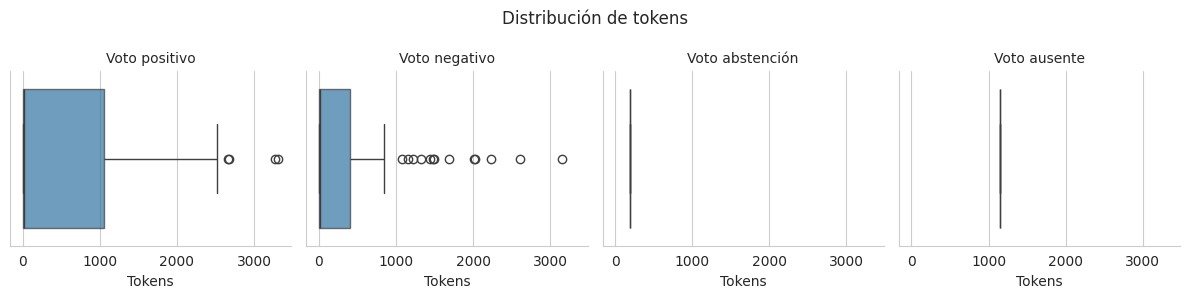

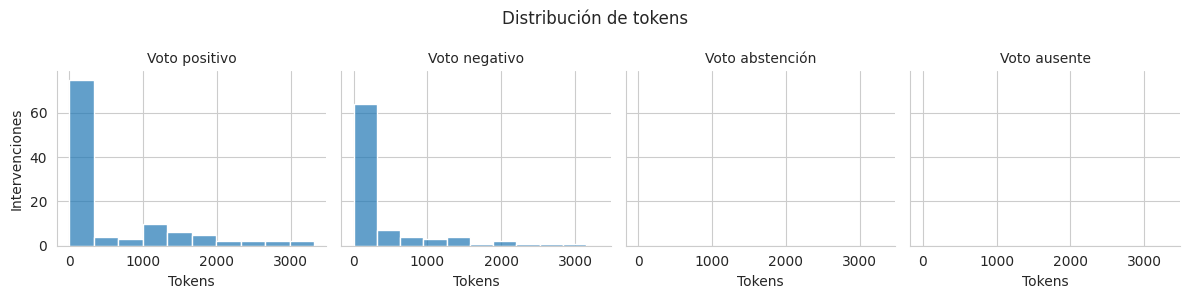

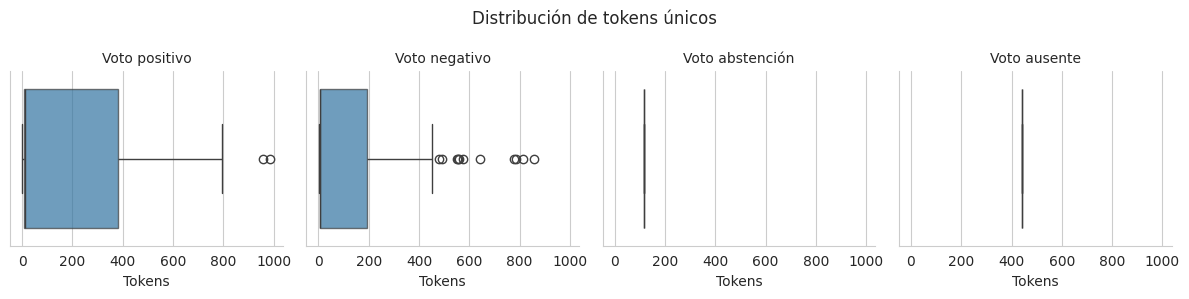

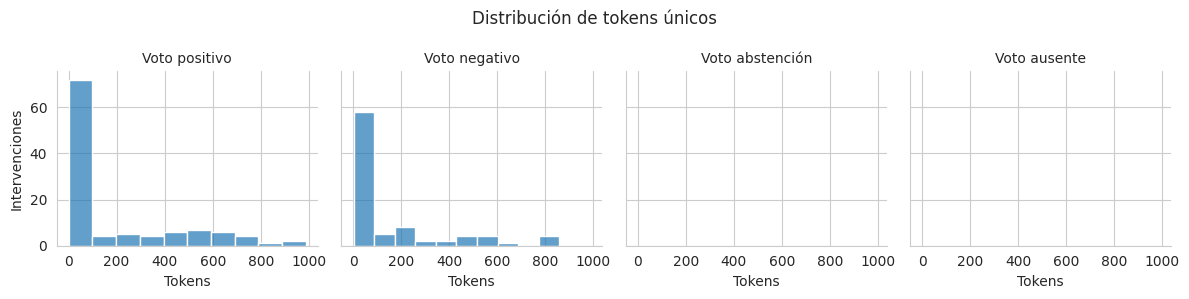

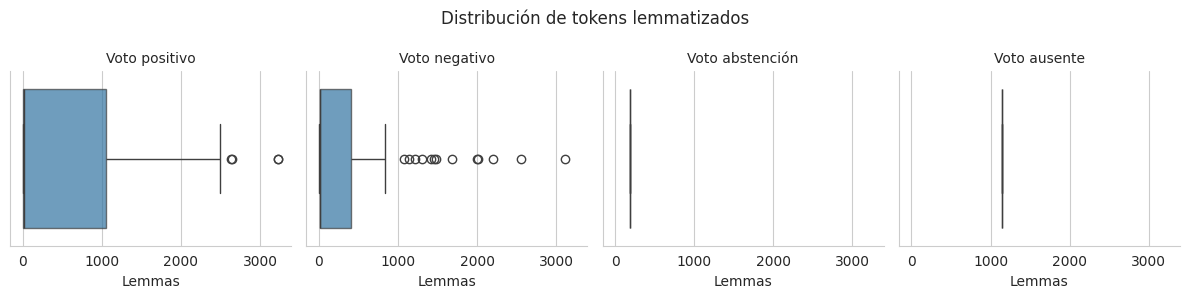

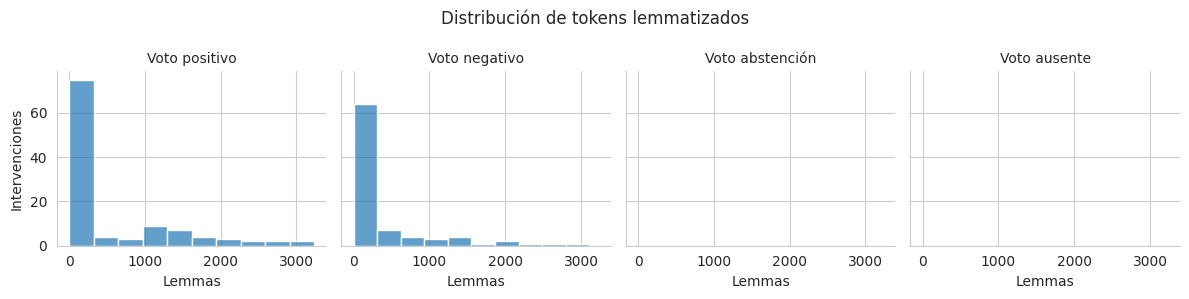

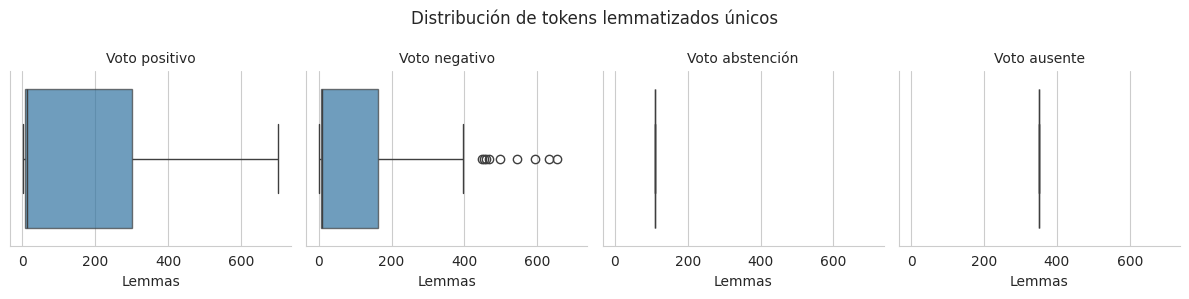

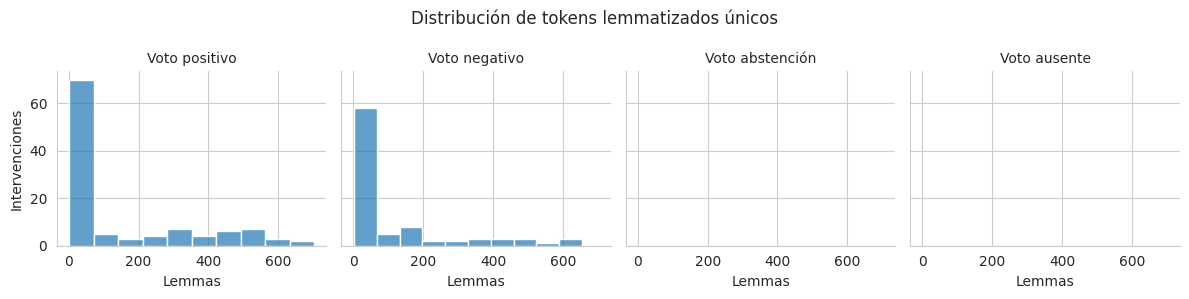

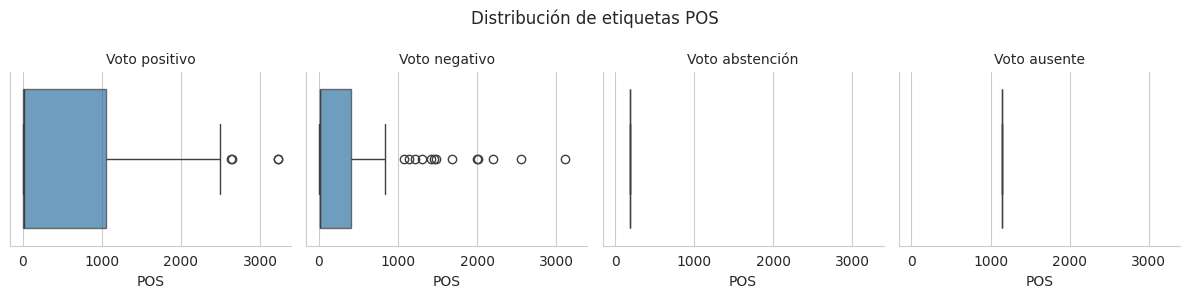

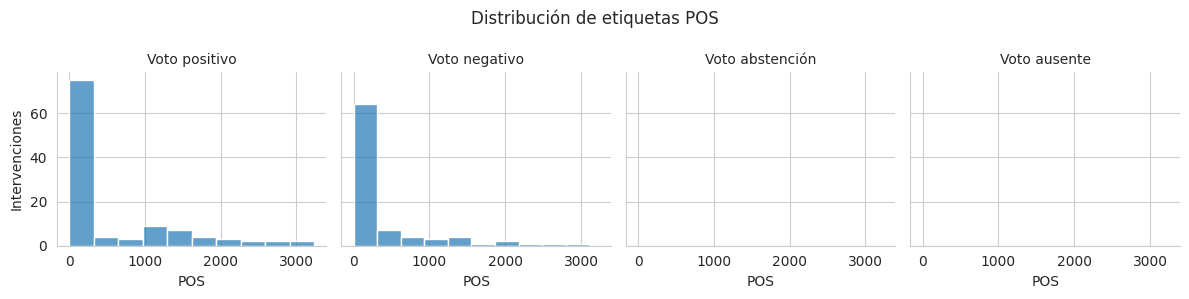

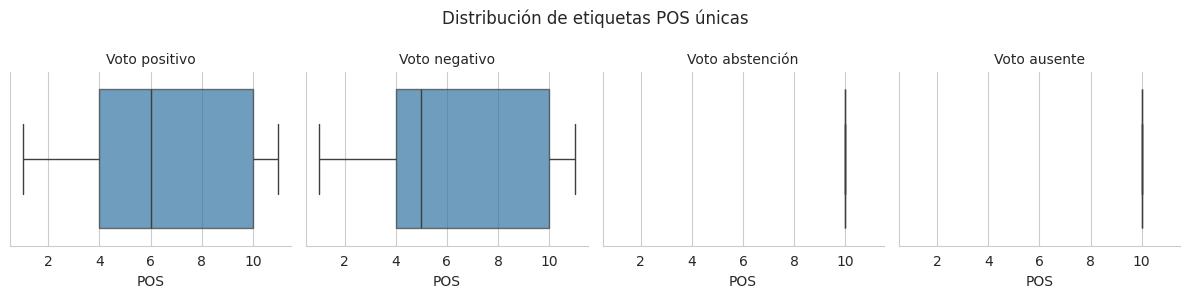

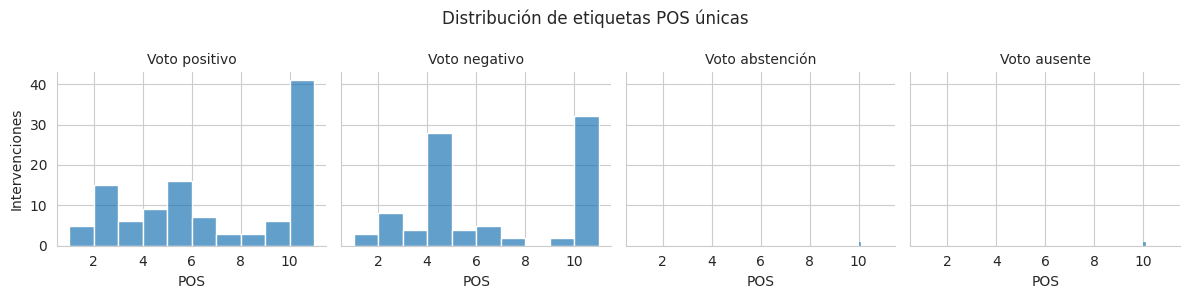

In [27]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_tokens_hue_vote")
os.makedirs(FOLDER, exist_ok=True)

cols = session_speech.filter(regex=r"speech_(.*?)_count").columns.tolist()
titles = [
    "Distribución de tokens",
    "Distribución de tokens únicos",
    "Distribución de tokens lemmatizados",
    "Distribución de tokens lemmatizados únicos",
    "Distribución de etiquetas POS",
    "Distribución de etiquetas POS únicas"
]
xlables = ["Tokens"]*2 + ["Lemmas"]*2 + ["POS"]*2

graphs = ["boxplot", "histplot"]

for col, title, label in zip(cols, titles, xlables):
    mean, meadian, std = calculate_univariant_metrics(
            session_speech[col], round_=3
        )
    for g in graphs:
        graph = getattr(sns, g)
        alpha = {"alpha": .7}
        kwargs = {"boxprops": alpha} if g=="boxplot" else {"bins": 10, **alpha}
        grid = sns.FacetGrid(session_speech, col="vote")
        grid.map_dataframe(graph, x=col, **kwargs)
        grid.set_xlabels(label)
        if g == "histplot":
            grid.set_ylabels("Intervenciones")
        grid.set_titles(col_template="Voto {col_name}")
        plt.suptitle(title)
        grid.tight_layout()
        grid.savefig(
            os.path.join(FOLDER,f"distrib_{g}_{col}_hue_vote.png")
        )

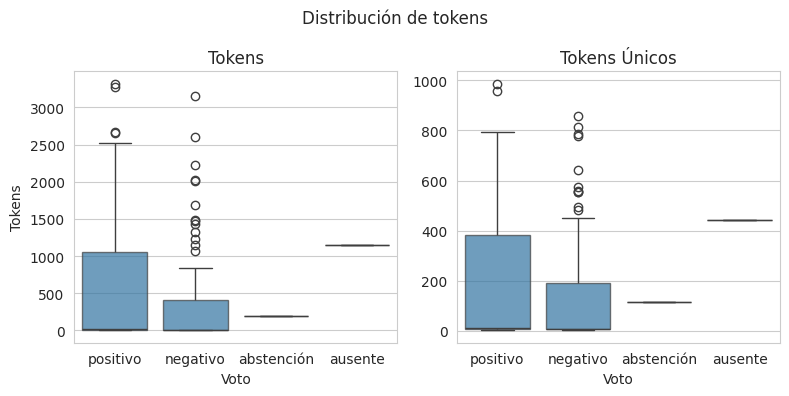

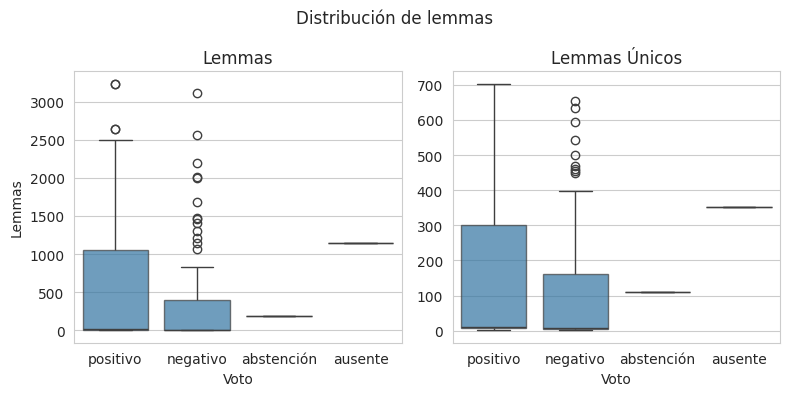

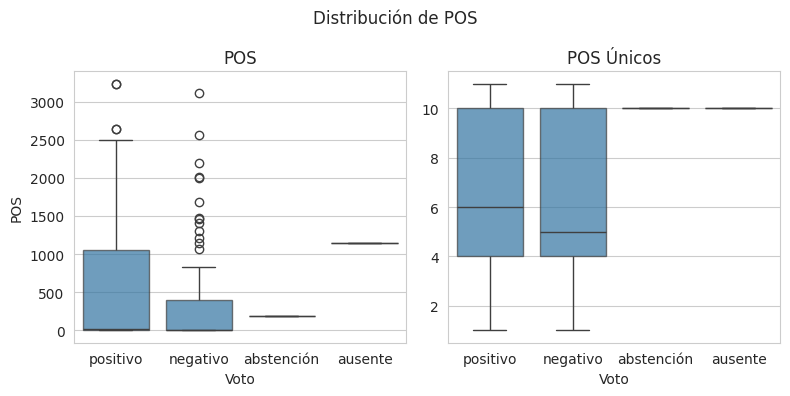

In [28]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_tokens_hue_unique")
os.makedirs(FOLDER, exist_ok=True)

cols_pair = [
    ["speech_preprocessed_count", "speech_preprocessed_count_unique"],
    ["speech_lemmas_count", "speech_lemmas_count_unique"],
    ["speech_pos_count", "speech_pos_count_unique"]
]
ylabels = ["Tokens", "Lemmas", "POS"]

for cols, label in zip(cols_pair, ylabels):
    i = 0
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    for col, title in zip(cols, titles):
        title = f"{label} Únicos" if "unique" in col else f"{label}"
        sns.boxplot(
            data=session_speech, x="vote", y=col,
            boxprops={"alpha": .7}, ax=axs[i]
        )
        axs[i].set_title(title)
        axs[i].set_xlabel("Voto")
        axs[i].set_ylabel(label)
        i += 1
    axs[i-1].set_ylabel("")
    suplabel = label.lower() if label != "POS" else label
    plt.suptitle(f"Distribución de {suplabel}")
    plt.tight_layout()
    plt.savefig(
        os.path.join(FOLDER,f"distrib_{suplabel.lower()}_hue_unique.png")
    )

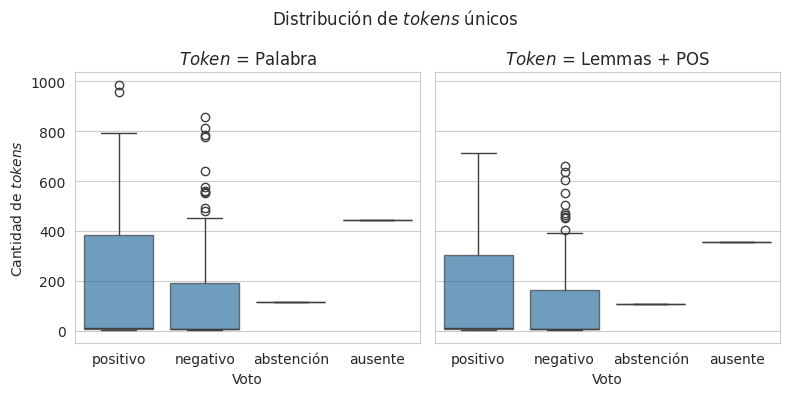

In [ ]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_tokens_vs_lemma_pos")
os.makedirs(FOLDER, exist_ok=True)

cols_pair = ["speech_preprocessed_count_unique", "speech_lemma_pos_count_unique"]
ylabels = ["Palabra", "Lemmas + POS"]

i = 0
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
for col, label in zip(cols_pair, ylabels):
    title = f"$Token$ = {label}"
    sns.boxplot(
        data=session_speech, x="vote", y=col,
        boxprops={"alpha": .7}, ax=axs[i]
    )
    axs[i].set_title(title)
    axs[i].set_xlabel("Voto")
    axs[i].set_ylabel("Cantidad de $tokens$")
    i += 1
plt.suptitle("Distribución de $tokens$ únicos")
plt.tight_layout()
plt.savefig(
    os.path.join(FOLDER,f"distrib_tokens_vs_lemma_pos.png")
)

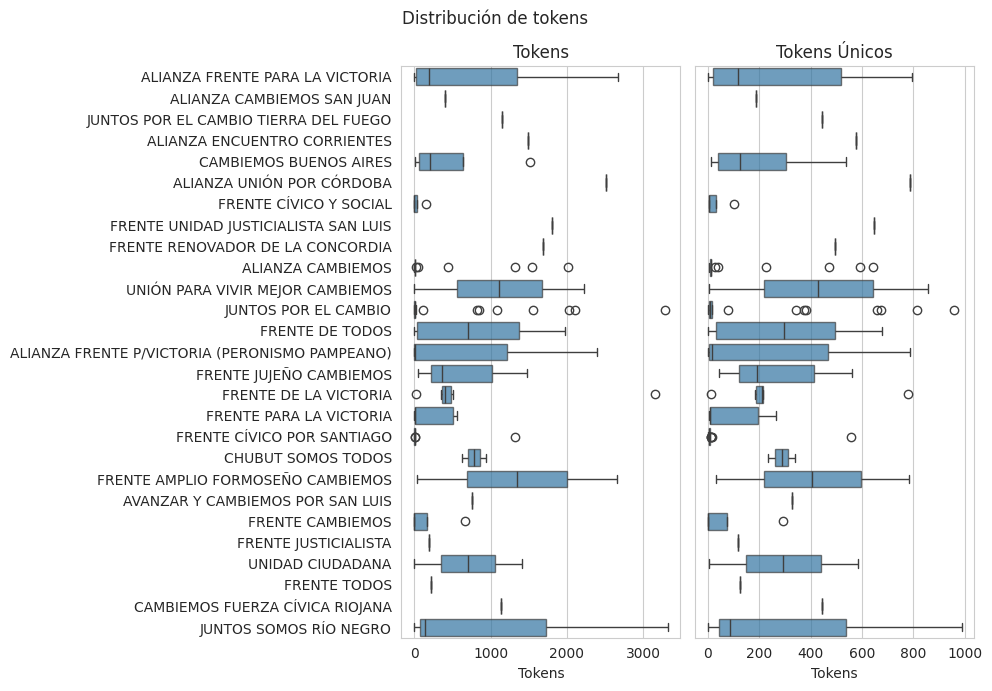

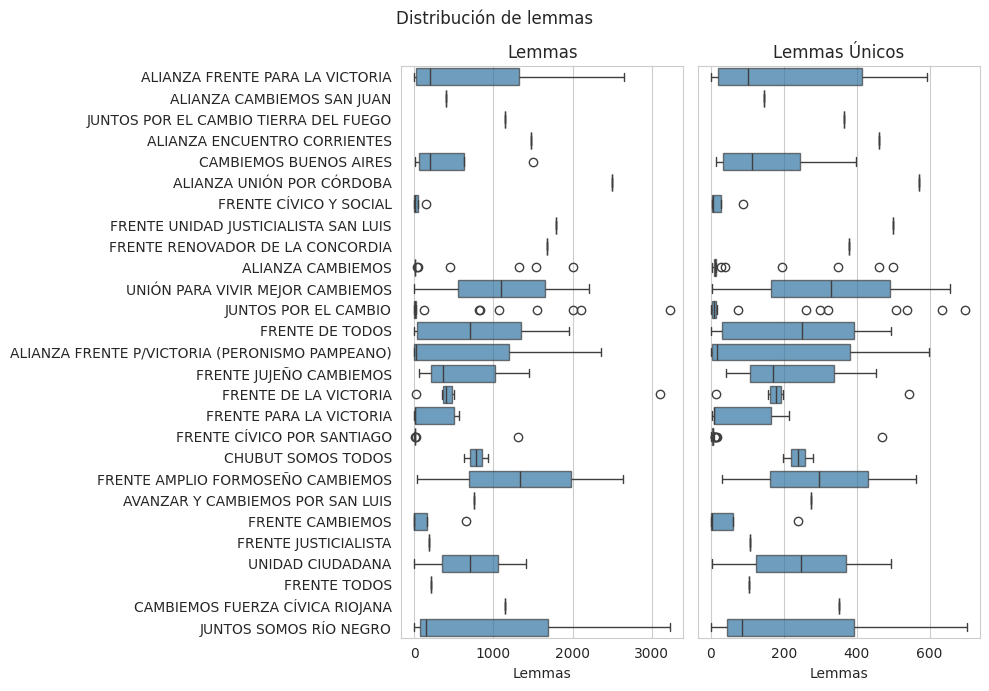

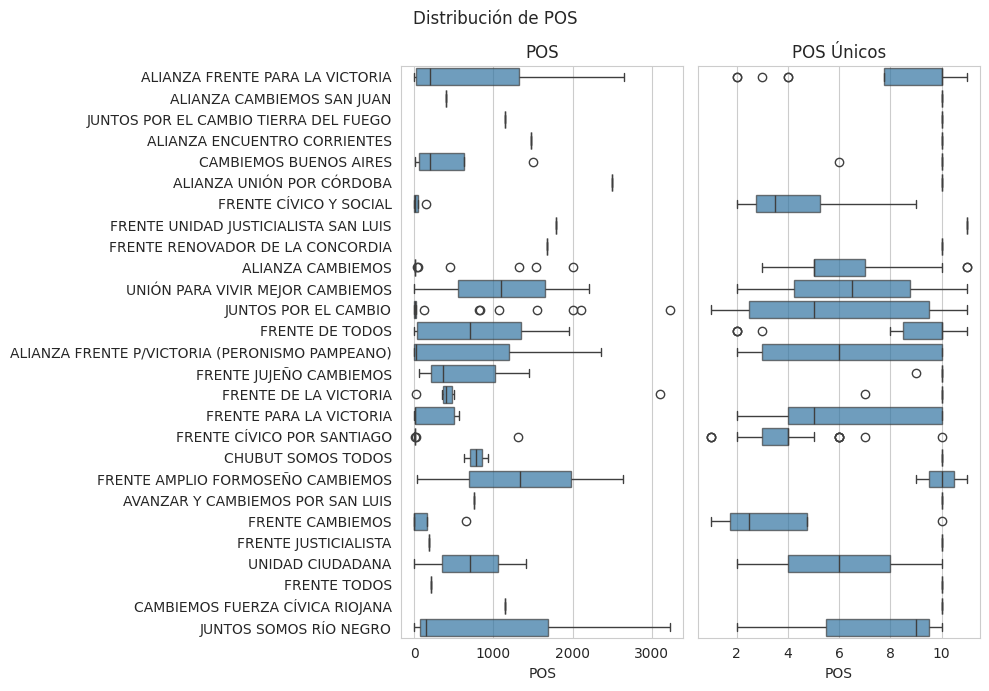

In [32]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "distrib_tokens_hue_unique_by_party")
os.makedirs(FOLDER, exist_ok=True)

cols_pair = [
    ["speech_preprocessed_count", "speech_preprocessed_count_unique"],
    ["speech_lemmas_count", "speech_lemmas_count_unique"],
    ["speech_pos_count", "speech_pos_count_unique"]
]
ylabels = ["Tokens", "Lemmas", "POS"]

for cols, label in zip(cols_pair, ylabels):
    i = 0
    fig, axs = plt.subplots(1, 2, figsize=(10,7), sharey=True)
    for col, title in zip(cols, titles):
        title = f"{label} Únicos" if "unique" in col else f"{label}"
        sns.boxplot(
            data=session_speech, y="party", x=col,
            boxprops={"alpha": .7}, ax=axs[i]
        )
        axs[i].set_title(title)
        axs[i].set_xlabel(label)
        axs[i].set_ylabel("")
        i += 1
    suplabel = label.lower() if label != "POS" else label
    plt.suptitle(f"Distribución de {suplabel}")
    plt.tight_layout()
    plt.savefig(
        os.path.join(FOLDER,f"distrib_{suplabel.lower()}_hue_unique_by_party.png")
    )

In [33]:
vectorizer = TfidfVectorizer(norm="l1", use_idf=False, smooth_idf=False, sublinear_tf=False)
X = vectorizer.fit_transform(session_speech.speech_pos)
pos = (
    pd.DataFrame(X.toarray(), columns=list(map(str.upper,vectorizer.get_feature_names_out())))
    .assign(vote=session_speech.vote)
    .melt(id_vars=["vote"], var_name="pos", value_name="f")
)
pos.head()

,vote,pos,f
0,positivo,AD,0.0
1,negativo,AD,0.0
2,negativo,AD,0.0
3,negativo,AD,0.0
4,negativo,AD,0.0


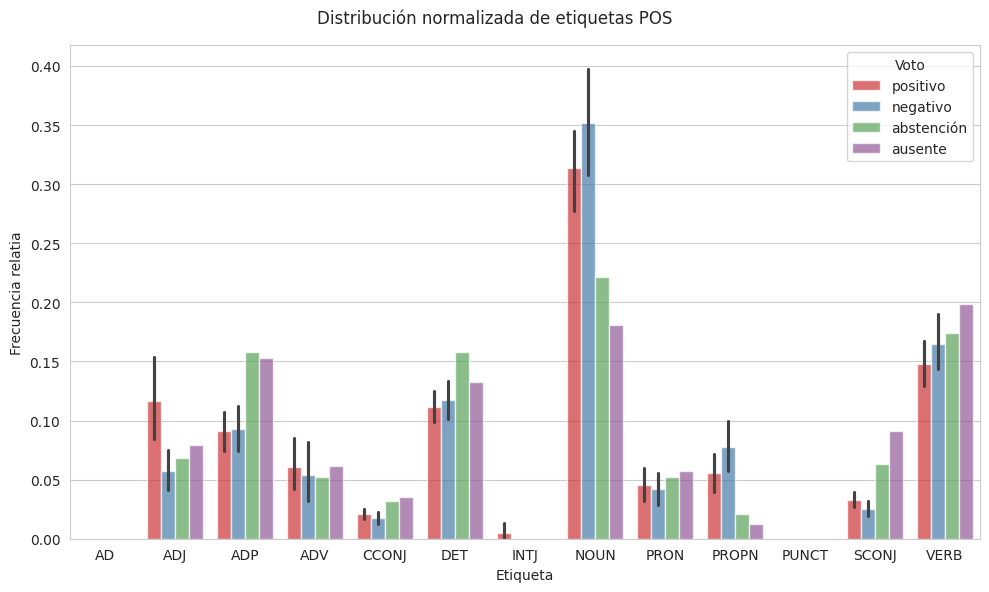

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pos, y="f", x="pos", hue="vote",  ax=ax, alpha=.7, palette="Set1")
plt.suptitle(f"Distribución normalizada de etiquetas POS")
ax.set_xlabel("Etiqueta")
ax.set_ylabel("Frecuencia relatia")
ax.legend_.set_title("Voto")
plt.tight_layout()
plt.savefig(
    os.path.join(FOLDER,f"distrib_pos_norm.png")
)